In [ ]:
from __future__ import print_function
import torch as t

In [ ]:
x = t.Tensor(5,3)
x

In [ ]:
x = t.rand(5,3)
x

In [ ]:
print(x.size())
x.size()[1],x.size(1)

In [ ]:
y = 2*t.rand(5,3)-1
y

In [ ]:
y = t.rand(5,3)
x + y

In [ ]:
t.add(x,y)

In [ ]:
result = t.Tensor(5,3)
t.add(x,y, out = result)
result

---

<span style ='color : magenta'>several ways of add function, one of them is inplace addition which changes the original y</span>

带下划线_的函数会改变Tensor本身

In [ ]:
print(y)

In [ ]:
y.add(x)
print(y)

In [ ]:
y.add_(x) #inline addition
print(y)

<em>tensor</em>和numpy的快速转换

In [ ]:
a = t.ones(5)
a

In [ ]:
b = a.numpy()
b

In [ ]:
import numpy as np
a = np.ones(5)
b = t.from_numpy(a)
print(a)
print(b)

### Tensor 和 numpy对象共享内存，一个变了另一个也会变

In [ ]:
b.add_(1)
print(a,b)

In [ ]:
t.cuda.is_available()

In [ ]:
if t.cuda.is_available():
    x = x.cuda()
    y = y.cuda()
    x+y

In [ ]:
print(x+y)

## 2.2.2Autograd
<b>autograd.Variable</b> 是核心类，封装了Tensor并且几乎支持所有Tensor操作。
<ol>
    <p>1.data</p>
    <p>2.grad 是Variable， 不是Tensor， 和data形状一致</p>
    <p>3.grad_fn</p>
</ol>

In [ ]:
from torch.autograd import Variable

In [ ]:
x = Variable(t.ones(2,2), requires_grad = True)
x

In [ ]:
y = x.sum()
y

In [ ]:
x.sum(axis = 1)

In [ ]:
y.grad_fn

In [ ]:
y.backward()


In [ ]:
x.grad

In [ ]:
y.backward()
x.grad

In [ ]:
x.grad.data.zero_()

In [ ]:
y.backward()
x.grad

In [ ]:
x = Variable(t.ones(4,5))
y = t.cos(x)
x_tensor_cos = t.cos(x.data)
print(y)
x_tensor_cos

In [ ]:
t.ones((4,5))

In [ ]:
print(x.shape)

In [ ]:
print(x.size())

## 2.2.3 torch.nn
<b>nn.Module</b>是最重要的类， 包含网络各层定义以及<b>forward</b>方法

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module): #inherit nn.Module
    def __init__(self):
        super(Net,self).__init__() #parent's constructor
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        
        #reshape, -1表示自适应
        x = x.view(x.size()[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

只要nn.Module定义了forward函数，就会自动定义相对应backward函数
可学习参数在net.parameters()返回，可同时返回可学习参数的名字及参数

In [ ]:
params = list(net.parameters())
print(len(params))

In [ ]:
for name, parameters in net.named_parameters():
    print(name, ":", parameters.size())

forward()函数输入输出都得是Variable才有auto_grad，所以传入x要先包装，才能自动求导

In [ ]:
input = Variable(t.randn(1,1,32,32))
out = net(input)
out.size()

In [ ]:
net.zero_grad()
out.backward(Variable(t.ones(1,10)))
print(net.conv1.bias.grad)

### 损失函数

In [ ]:
output = net(input)
target = Variable(t.arange(0,10))
criterion = nn.MSELoss()
loss = criterion(output,target.float())
loss

In [ ]:
#loss.grad_fn

In [ ]:
net.zero_grad()
print("before backprop")
print(net.conv1.bias.grad)
print(loss.type())
loss.backward()
print("after backprop")
print(net.conv1.bias.grad)

### optimizer

In [ ]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(),lr = 0.01)

optimizer.zero_grad()
output = net(input)
loss = criterion(output,target.float())

loss.backward()
optimizer.step()

## 数据加载和预处理 -- torchvision

In [4]:
import torch as t
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage()

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

trainset = tv.datasets.CIFAR10(
    root = 'F:\\pyTorch\\datasets',
    train = True,
    download = True,
    transform = transform
)

Files already downloaded and verified


In [6]:
trainloader = t.utils.data.DataLoader(
    trainset,
    batch_size =4,
    shuffle = True,
    num_workers = 2
)

testset = tv.datasets.CIFAR10(
    "F:\\pyTorch\\datasets",
    train = False,
    #download = true,
    transform = transform
)

testloader = t.utils.data.DataLoader(
    testset,
    batch_size = 4,
    shuffle = False,
    num_workers =2
)

In [7]:
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

In [8]:
(data,label) = trainset[100]
print(classes[label])
print(show)
#show((data+1)/2).resize((150,150))

ship
ToPILImage()


<span style = "color: cyan">DataLoader</span>是一个可迭代的对象

        dog         dog        frog         cat


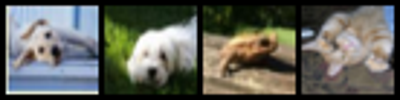

In [9]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(' '.join('%11s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images+1)/2)).resize((400,100))